## Outlier filtering

A very important step in processing data is outlier filtering. An outlier can simply be defined as an exception; In this case, an entry that seems very unusual compared to the general pattern of the data.  
For the purpose of this project, I want to train a model that is generic, i.e, a model that can be a good representation of house prices in Bengaluru. If we do not get rid of outliers in the data, it will definitely skew the prospective model.  
Hence, we'll detect these outliers and deal with them appropriately.

In [1]:
# Import necessary packages.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ignoring all unnecessary warnings.
pd.set_option('mode.chained_assignment', None)

We'll load the dataframe we processed from the last notebook.

In [2]:
%store -r df1
df1.head()

,location,total_sqft,bath,price,bedrooms,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In the last notebook, we saw all the entries where sqft per bedroom was below __320sqft__. This time around, we'll create a new dataframe where we remove all entries where sqft per bedroom is below __320sqft__.

In [3]:
# Filter all entry where total_sqft/bedrooms is below 320sqft.
df = df1[~(df1.total_sqft/df1.bedrooms<320)]

# Compare samples before and after filtering.
df1.shape, df.shape

((13246, 6), (12279, 6))

Perfect! We can see we have lost some samples of the data.  
Another typical form of outlier in this type of dataset will be houses that are overly cheap or overly expensive.  
With the __price_per_sqft__ feature we engineered in the previous notebook, we can easily determine houses that are too cheap or too expensive.  
<br>
Let's see some statistical info on the __price_per_sqft__ column...

In [4]:
# Simple Statistics on price_per_sqft.
df.price_per_sqft.describe()

count     12233.000000
mean       6205.841652
std        4049.334161
min         267.829813
25%        4200.000000
50%        5263.157895
75%        6818.181818
max      176470.588235
Name: price_per_sqft, dtype: float64

From the above insight, we can see that the average cost per sqft is 6300. However there is an entry where the cost per sqft is 267 and another where it is 176470. What a chasm!
<br>
The best practice of filtering this outliers is by removing any entry that lies beyond a specific threshold. Example, we can set a threshold of 2 standard deviation greater or less than the mean. Hence, any entry that lies beyond or before this threshold is effectively filtered.

In [5]:
def filter_outliers1(dataframe):
    ''' 
        This function takes the dataframe, and groupby the location.

        For each location, we calculate the mean and standard deviation of the 
        price_per_sqft in that location.

        Then we use the mean and standard deviation to filter entries that lie beyond some 
        specified threshold.
    '''
    df = pd.DataFrame()
    for location, minidf in dataframe.groupby('location'):
        mean = np.mean(minidf.price_per_sqft)
        std = np.std(minidf.price_per_sqft)
        filtered_df = minidf[(minidf.price_per_sqft>(mean-(std*1.5))) & (minidf.price_per_sqft<=(mean+(std*1.5)))]
        df = pd.concat([df, filtered_df], ignore_index=True)
    return df

In the above function, notice how I group by location. This is very important because, cost varies from location to location and it will be insensible to just filter outliers with paying regards to locations.

In [6]:
df2 = filter_outliers1(df)
df2.shape

(11262, 6)

We got rid of quite some entries there.  
<br>
Let's have a look at the bedrooms column...

In [7]:
# Number of houses in each "bedrooms" value.
df2.groupby('bedrooms')['bedrooms'].agg('count')

bedrooms
1      572
2     5212
3     4388
4      829
5      125
6       65
7       32
8       19
9       13
10       3
11       2
13       1
16       1
Name: bedrooms, dtype: int64

Apparently, most houses have 2 or 3 bedrooms.  
I'm very much curious to see how prices vary between houses with 2 and 3 bedrooms in the same location.  
We can visualize these differences through a scatter plot. We'll plot the total_sqft against price_per_sqft....

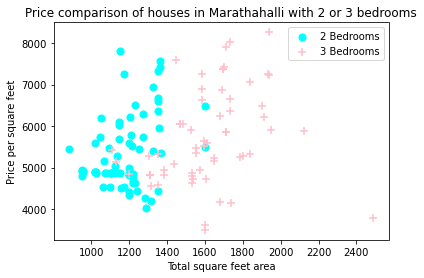

In [8]:
def scatter_plot(dataframe, location):
    bedrooms2 = dataframe[(dataframe.location==location) & (dataframe.bedrooms==2)]
    bedrooms3 = dataframe[(dataframe.location==location) & (dataframe.bedrooms==3)]
    plt.scatter(bedrooms2.total_sqft, bedrooms2.price_per_sqft, color='cyan', label='2 Bedrooms', s=50)
    plt.scatter(bedrooms3.total_sqft, bedrooms3.price_per_sqft, marker='+', color='pink', label='3 Bedrooms', s=50)
    plt.xlabel('Total square feet area')
    plt.ylabel('Price per square feet')
    plt.title(f'Price comparison of houses in {location} with 2 or 3 bedrooms')
    plt.legend()

scatter_plot(df2, 'Marathahalli')

See how some 3 bhk houses cost less than 2 bhk houses with the same total square feet area.<br>
Normally you'll think that, in the same location, for more bhk, the price of a given house should<br>cost more than one with less bhk, provided the square feet area is fairly same.
<br>
So I'll go ahead and write a function that filters these outliers.

In [9]:
def filter_outliers2(dataframe):
    '''First, I create an empty array that would hold the indices of the 
       outliers to filter/remove; filter_indices.
       
       Second, I group the dataframe by location; location_df
       
       Third, I create an empty dictionary 'bedroom_info', and then group 'location_df' by 'bedrooms'
       
       Fourth, I get the mean and standard deviation of the price per square feet of all the
       house with a particular number of bedrooms in a particular Location. Also the count of the houses.
       
       Finally, I will use these statistical info to filter appropriate entries.
      '''
    filter_indices = np.array([])
    for location, location_df in dataframe.groupby('location'):
        bedroom_info = {}
        for bedroom, bedroom_df in location_df.groupby('bedrooms'):
            bedroom_info[bedroom] = {
                'mean': np.mean(bedroom_df.price_per_sqft),
                'std': np.std(bedroom_df.price_per_sqft),
                'count': bedroom_df.shape[0]
            }
        for bedroom, bedroom_df in location_df.groupby('bedrooms'):
            info = bedroom_info.get(bedroom-1)
            # Ignoring bedroom values that have less than 5 count.
            if info and info['count']>5:
                filter_indices = np.append(filter_indices, 
                             bedroom_df[bedroom_df.price_per_sqft<(info['mean'])].index.values)
                
    # Drop outliers index-wise.
    return dataframe.drop(filter_indices, axis='index')

df3 = filter_outliers2(df2)
df3.shape

(8005, 6)

That took quite a while to process.  
We can run the scatter plot again to see how our function worked out...

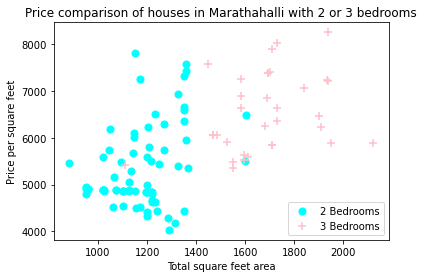

In [10]:
scatter_plot(df3, 'Marathahalli')

We succeeded in filtering most of those outliers. It would also be important to notice that sometimes outlier filtering is not 100% efficient, especially when it is automated. The computer might make slim omissions, but it is good enough.
<br>
Let's examine the bath column...

In [11]:
df3.bath.unique()

array([ 4.,  3.,  2.,  1.,  8.,  5.,  7.,  6.,  9., 12., 10., 14., 16.,
       13.])

Wow! There are houses with over 9 bathrooms.  
We can have a look at all the houses that have more than 9 bathrooms.

In [12]:
# The entries in the dataset where bath is greater than 9.
df3[df3.bath>9]

,location,total_sqft,bath,price,bedrooms,price_per_sqft
5912,Neeladri Nagar,4000.0,12.0,160.0,10,4000.000000
8008,Vidyaranyapura,4700.0,10.0,130.0,9,2765.957447
9133,other_locations,3300.0,14.0,500.0,9,15151.515152
9580,other_locations,10000.0,16.0,550.0,16,5500.000000
10314,other_locations,6000.0,12.0,150.0,11,2500.000000
10653,other_locations,5425.0,13.0,275.0,13,5069.124424


Okay there are only a few entries like that in the dataset.  
We will use a histogram to see the distribution of bathrooms accross the dataset.

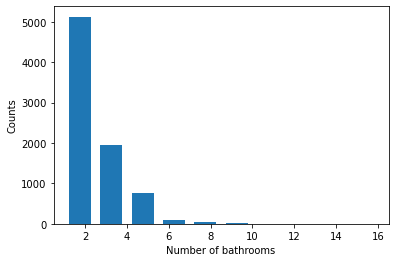

In [13]:
# Histogram showing frequency of bathrooms.
plt.hist(df3.bath, rwidth=.7)
plt.xlabel('Number of bathrooms')
plt.ylabel('Counts')
plt.show()

From the dataframe, we can see that there are houses that have more bathrooms than bedrooms. Incredible!  
<br>
This could be a subjective take, but I personally don't see a reason why a house would have more bathrooms than bedrooms. This would certainly be an anomaly.  
Let's have a look at entries where there are more than two extra bathrooms.

In [14]:
# Houses with excess bathrooms
df3[df3.bath>df3.bedrooms+2]

,location,total_sqft,bath,price,bedrooms,price_per_sqft
1784,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5863,Nagasandra,7000.0,8.0,450.0,4,6428.571429
7608,Thanisandra,1806.0,6.0,116.0,3,6423.034330
9133,other_locations,3300.0,14.0,500.0,9,15151.515152
9418,other_locations,11338.0,9.0,1000.0,6,8819.897689


Yowza! There is a house that has 2 times more bathrooms than bedrooms, Incredible!  
<br>
Considerately, I will spare entries that have at most 1 extra bathroom.  
We will create a new dataframe and make that effect.

In [15]:
df4 = df3[df3.bath<df3.bedrooms+2]
df4.shape

(7910, 6)

Fine, we filtered almost 100 entries there.  
Moving on....
<br>
As I earlier mentioned in the previous notebook, sometimes engineered features can be used to make smoother analysis and we've seen that so far. We used the price_per_sqft column to facilitate most of the outlier filtering.  
However, we do not need this feature in training the model hence, we'll drop this column.

In [16]:
df5 = df4.drop(['price_per_sqft'], axis=1)
df5.head()

,location,total_sqft,bath,price,bedrooms
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


We'll save the processed dataframe.  
We'll use the dataframe in the next notebook... __Regression modelling__.

In [17]:
%store df5

Stored 'df5' (DataFrame)


In [18]:
# ifunanyaScript